## import

In [3]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add, Dense
from keras.layers.core import Lambda, Reshape, Flatten
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.pooling import MaxPooling2D, GlobalMaxPooling2D
from keras.layers.merge import concatenate, Dot, Multiply
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import keras
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img#,save_img
from keras.callbacks import CSVLogger


from keras.optimizers import SGD, Adam, Adadelta, RMSprop
from keras.regularizers import l2


import keras.backend.tensorflow_backend as KTF
config = tf.ConfigProto()  
config.gpu_options.allow_growth=True   
session = tf.Session(config=config)
KTF.set_session(session)

print(keras.__version__)
print(tf.__version__)

2.2.0
1.10.0


In [49]:
import gc

## data

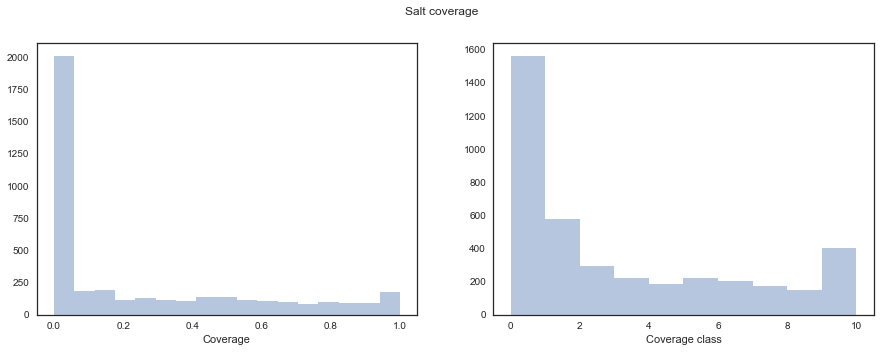

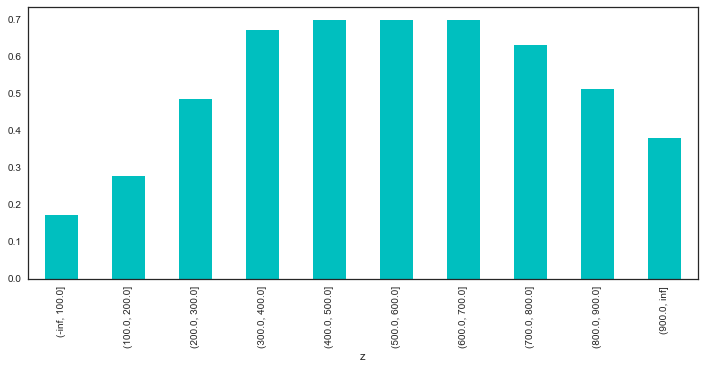

In [4]:
# Set some parameters
exp_code = "029"
img_size_ori = 101
img_size_target = 101
im_width = 101
im_height = 101
im_chan = 1
basicpath = './data/'
path_train = basicpath + 'train/'
path_test = basicpath + 'test/'

path_train_images = path_train + 'images/'
path_train_masks = path_train + 'masks/'
path_test_images = path_test + 'images/'

# Loading of training/testing ids and depths

train_df = pd.read_csv("./data/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("./data/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

train_df["images"] = [np.array(load_img("./data/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

train_df["masks"] = [np.array(load_img("./data/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")
plt.show()

z_cut = pd.cut(train_df.z, [-np.Inf, 100, 200, 300, 400, 500, 600, 700, 800, 900, np.Inf])
c_cut = pd.cut(train_df.coverage, [-np.Inf, 0.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, np.Inf], labels=range(11))
train_df["c1"] = (train_df.coverage > 0).astype("int")
train_df["z_cut"] = z_cut
train_df["c_cut"] = c_cut

z_group = train_df.groupby(z_cut)
(z_group.c1.sum() / z_group.c1.size()).plot(kind="bar", color="c", figsize=(12, 5))
plt.show()

## 5fold-split --seed 123

In [5]:
from sklearn.model_selection import StratifiedKFold

X = np.array(train_df.images.tolist()).reshape(-1, img_size_target, img_size_target, 1)
Y = np.array(train_df.masks.tolist()).reshape(-1, img_size_target, img_size_target, 1)
y = train_df.c_cut.values.copy()

skf = StratifiedKFold(n_splits=5, random_state=123)
skf.get_n_splits(X, y)
kfold_index = [ob for ob in skf.split(X, y)]

y.shape

for train_idx, valid_idx in kfold_index:
    print(train_idx.shape, valid_idx.shape)

(3196,) (804,)
(3199,) (801,)
(3200,) (800,)
(3201,) (799,)
(3204,) (796,)


##  loss & metric

In [85]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None, use_relu=True):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab, use_relu=use_relu)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore), use_relu=use_relu)
    return loss


def lovasz_hinge_flat(logits, labels, use_relu=True):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.elu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        # if use_relu:
        #     loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        #     # loss = tf.tensordot(tf.nn.elu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void") ## !!
        # else:
        #     loss = tf.tensordot(tf.nn.elu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void") ## !!
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image=True, ignore=None, use_relu=True)
    return loss


def lovasz_loss_elu(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image=True, ignore=None, use_relu=False)
    return loss

In [79]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
#             metric.append(1)
#             continue
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred > 0], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred > .45], tf.float64)

## model --base

In [86]:
ACTIVATION = "relu"
def gen_conv_names(base):
    conv_name = base + '_conv'
    bn_name = base + "_bn"
    act_name = base + "_{}".format(ACTIVATION)
    return conv_name, bn_name, act_name

def convolution_block(base_name, x, filters, size, strides=(1,1), padding='same', activation=True):
    conv_name, bn_name, act_name = gen_conv_names(base_name)
    x = Conv2D(filters, size, strides=strides, padding=padding, name=conv_name)(x)
    x = BatchNormalization(name=bn_name)(x)
    if activation == True:
        x = Activation(ACTIVATION, name=act_name)(x)
    return x

def se_block(blockInput, bottle=4):
    channel_cnt = int(blockInput.shape[-1])
    
    x = GlobalMaxPooling2D(data_format="channels_last")(blockInput)
    x = Dense(int(channel_cnt / bottle))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dense(channel_cnt)(x)
    x = Activation("sigmoid")(x)
    x = Reshape((1, 1, channel_cnt))(x)
    x = Multiply()([blockInput, x])
    return x

def scse_block(blockInput, bottle=4, ssigmoid=False, alpha=0.0001):
    channel_cnt = int(blockInput.shape[-1])
    img_size = int(blockInput.shape[1])
    img_size2 = img_size * img_size

    x = GlobalMaxPooling2D(data_format="channels_last")(blockInput)
    x = Dense(int(channel_cnt / bottle))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dense(channel_cnt, kernel_regularizer=l2(0.001))(x)
    x = Activation("sigmoid")(x)
    x = Reshape((1, 1, channel_cnt))(x)
    x = Multiply()([blockInput, x])
    

    y = Conv2D(1, (1, 1), padding="same")(blockInput)
    if ssigmoid:
        y = Activation("elu")(y)
    if img_size >= 50:
        y_pooling = (4, 4) if img_size % 2 == 1 else (2, 2)
        kernel_size = (5, 5) if img_size % 2 == 1 else (3, 3)
        padding = "valid" if img_size % 2 == 1 else "same"
        
        y = MaxPooling2D(y_pooling)(y)

        pool_size = int(y.shape[1])
        pool_size2 = pool_size * pool_size

        y = Reshape((pool_size2, ))(y)
        y = Dense(int(pool_size2 / bottle))(y)
        y = BatchNormalization()(y)
        y = Activation("relu")(y)
        y = Dense(pool_size2, kernel_regularizer=l2(alpha))(y)
        y = Activation("sigmoid")(y)
        y = Reshape((pool_size, pool_size, 1))(y)
        y = Conv2DTranspose(1, kernel_size, strides=y_pooling, padding=padding)(y)
    else:
        y = Reshape((img_size2, ))(y)
        y = Dense(int(img_size2 / bottle))(y)
        y = BatchNormalization()(y)
        y = Activation("relu")(y)
        y = Dense(img_size2, kernel_regularizer=l2(alpha))(y)
        y = Activation("sigmoid")(y)
        y = Reshape((img_size, img_size, 1))(y)

    y = Multiply()([blockInput, y])

    z = Add()([x, y])
    return z


def residual_block(base_name, blockInput, num_filters=16, use_se=False, ssigmoid=False, se_l2_alpha=0.0001):
    x = Activation(ACTIVATION, name=base_name + "_{}".format(ACTIVATION))(blockInput)
    x = BatchNormalization(name=base_name + "_bn")(x)
    x = convolution_block(base_name + "_1", x, num_filters, (3,3) )
    x = convolution_block(base_name + "_2", x, num_filters, (3,3), activation=False)
    if use_se:
        x = scse_block(x, ssigmoid=ssigmoid, alpha=se_l2_alpha)
    x = Add(name=base_name + "_add")([blockInput, x])
    return x

# Build model
def _build_model(input_layer, start_neurons, DropoutRatio=0.5, use_se=False, use_sigmoid=True, ssigmoid=False, se_l2_alpha=0.0001):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="en1_a_conv")(input_layer)
    conv1 = residual_block("en1_b", conv1, start_neurons * 1, use_se=use_se, ssigmoid=ssigmoid, se_l2_alpha=se_l2_alpha)
    conv1 = residual_block("en1_c", conv1, start_neurons * 1, use_se=use_se, ssigmoid=ssigmoid, se_l2_alpha=se_l2_alpha)
    conv1 = Activation(ACTIVATION)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="en2_a_conv")(pool1)
    conv2 = residual_block("en2_b", conv2, start_neurons * 2, use_se=use_se, ssigmoid=ssigmoid, se_l2_alpha=se_l2_alpha)
    conv2 = residual_block("en2_c", conv2, start_neurons * 2, use_se=use_se, ssigmoid=ssigmoid, se_l2_alpha=se_l2_alpha)
    conv2 = Activation(ACTIVATION)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="en3_a_conv")(pool2)
    conv3 = residual_block("en3_b", conv3, start_neurons * 4, use_se=use_se, ssigmoid=ssigmoid, se_l2_alpha=se_l2_alpha)
    conv3 = residual_block("en3_c", conv3, start_neurons * 4, use_se=use_se, ssigmoid=ssigmoid, se_l2_alpha=se_l2_alpha)
    conv3 = Activation(ACTIVATION)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="en4_a_conv")(pool3)
    conv4 = residual_block("en4_b", conv4, start_neurons * 8, use_se=use_se, ssigmoid=ssigmoid, se_l2_alpha=se_l2_alpha)
    conv4 = residual_block("en4_c", conv4, start_neurons * 8, use_se=use_se, ssigmoid=ssigmoid, se_l2_alpha=se_l2_alpha)
    conv4 = Activation(ACTIVATION)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same", name="vm_a_conv")(pool4)
    convm = residual_block("vm_b", convm, start_neurons * 16, use_se=False)
    convm = residual_block("vm_c", convm, start_neurons * 16, use_se=False)
    convm = Activation(ACTIVATION)(convm)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="de4_a_conv")(uconv4)
    uconv4 = residual_block("de4_b", uconv4, start_neurons * 8, use_se=use_se, ssigmoid=ssigmoid, se_l2_alpha=se_l2_alpha)
    uconv4 = residual_block("de4_c", uconv4, start_neurons * 8, use_se=use_se, ssigmoid=ssigmoid, se_l2_alpha=se_l2_alpha)
    uconv4 = Activation(ACTIVATION)(uconv4)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="de3_a_conv")(uconv3)
    uconv3 = residual_block("de3_b", uconv3, start_neurons * 4, use_se=use_se, ssigmoid=ssigmoid, se_l2_alpha=se_l2_alpha)
    uconv3 = residual_block("de3_c", uconv3, start_neurons * 4, use_se=use_se, ssigmoid=ssigmoid, se_l2_alpha=se_l2_alpha)
    uconv3 = Activation(ACTIVATION)(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="de2_a_conv")(uconv2)
    uconv2 = residual_block("de2_b", uconv2, start_neurons * 2, use_se=use_se, ssigmoid=ssigmoid, se_l2_alpha=se_l2_alpha)
    uconv2 = residual_block("de2_c", uconv2, start_neurons * 2, use_se=use_se, ssigmoid=ssigmoid, se_l2_alpha=se_l2_alpha)
    uconv2 = Activation(ACTIVATION)(uconv2)
    
    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="de1_a_conv")(uconv1)
    uconv1 = residual_block("de1_b", uconv1,start_neurons * 1, use_se=use_se, ssigmoid=ssigmoid, se_l2_alpha=se_l2_alpha)
    uconv1 = residual_block("de1_c", uconv1,start_neurons * 1, use_se=use_se, ssigmoid=ssigmoid, se_l2_alpha=se_l2_alpha)
    uconv1 = Activation(ACTIVATION)(uconv1)
    
    uconv1 = Dropout(DropoutRatio / 2)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", name="final_conv")(uconv1)

    if use_sigmoid:
        output_layer = Activation("sigmoid")(output_layer)
    
    return output_layer

## model structure --base

In [10]:
model = build_model(101)

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 101, 101, 2)  0                                            
__________________________________________________________________________________________________
en1_a_conv (Conv2D)             (None, 101, 101, 16) 304         input[0][0]                      
__________________________________________________________________________________________________
en1_b_relu (Activation)         (None, 101, 101, 16) 0           en1_a_conv[0][0]                 
__________________________________________________________________________________________________
en1_b_bn (BatchNormalization)   (None, 101, 101, 16) 64          en1_b_relu[0][0]                 
__________________________________________________________________________________________________
en1_b_1_co

__________________________________________________________________________________________________
activation_2 (Activation)       (None, 50, 50, 32)   0           en2_c_add[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 25, 25, 32)   0           activation_2[0][0]               
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 25, 25, 32)   0           max_pooling2d_2[0][0]            
__________________________________________________________________________________________________
en3_a_conv (Conv2D)             (None, 25, 25, 64)   18496       dropout_2[0][0]                  
__________________________________________________________________________________________________
en3_b_relu (Activation)         (None, 25, 25, 64)   0           en3_a_conv[0][0]                 
__________

en4_c_add (Add)                 (None, 12, 12, 128)  0           en4_b_add[0][0]                  
                                                                 en4_c_2_bn[0][0]                 
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 12, 12, 128)  0           en4_c_add[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 6, 6, 128)    0           activation_4[0][0]               
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 6, 6, 128)    0           max_pooling2d_4[0][0]            
__________________________________________________________________________________________________
vm_a_conv (Conv2D)              (None, 6, 6, 256)    295168      dropout_4[0][0]                  
__________

__________________________________________________________________________________________________
de4_c_2_conv (Conv2D)           (None, 12, 12, 128)  147584      de4_c_1_relu[0][0]               
__________________________________________________________________________________________________
de4_c_2_bn (BatchNormalization) (None, 12, 12, 128)  512         de4_c_2_conv[0][0]               
__________________________________________________________________________________________________
de4_c_add (Add)                 (None, 12, 12, 128)  0           de4_b_add[0][0]                  
                                                                 de4_c_2_bn[0][0]                 
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 12, 12, 128)  0           de4_c_add[0][0]                  
__________________________________________________________________________________________________
conv2d_tra

__________________________________________________________________________________________________
de2_c_bn (BatchNormalization)   (None, 50, 50, 32)   128         de2_c_relu[0][0]                 
__________________________________________________________________________________________________
de2_c_1_conv (Conv2D)           (None, 50, 50, 32)   9248        de2_c_bn[0][0]                   
__________________________________________________________________________________________________
de2_c_1_bn (BatchNormalization) (None, 50, 50, 32)   128         de2_c_1_conv[0][0]               
__________________________________________________________________________________________________
de2_c_1_relu (Activation)       (None, 50, 50, 32)   0           de2_c_1_bn[0][0]                 
__________________________________________________________________________________________________
de2_c_2_conv (Conv2D)           (None, 50, 50, 32)   9248        de2_c_1_relu[0][0]               
__________

 6,934,295

## add depth info

In [12]:
img_size = 101

def create_depth_figure(img_size):
    depth_figure = np.zeros((img_size, img_size))
    for i, d in enumerate(np.linspace(0.01, 1, img_size)):
        depth_figure[i, :] = d
    return depth_figure

depth_figure = create_depth_figure(101)

def append_depth_channel(img):
    global depth_figure
    shape = list(img.shape)
    shape[-1] = 2
    new_img = np.zeros(shape)
    new_img[:, :, 0] = img[:, : , 0]
    new_img[:, :, 1] = depth_figure
    return new_img

def append_depth_channel_2(img):
    global depth_figure
    shape = list(img.shape)
    shape[-1] = 3
    new_img = np.zeros(shape)
    new_img[:, :, 0] = img[:, : , 0]
    new_img[:, :, 1] = depth_figure
    new_img[:, :, 2] = depth_figure * img[:, : , 0]
    return new_img

## train --fold 0

In [43]:
def build_model(img_size_target):
    input_layer = Input((img_size_target, img_size_target, 2), name="input")
    output_layer = _build_model(input_layer, 16, 0.5, use_sigmoid=True)

    model = Model(input_layer, output_layer)
    # model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[my_iou_metric_2])
    # c = SGD(lr=0.05, momentum=.9, decay=1e-6)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[my_iou_metric_2])
    # model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric])
    return model

In [13]:
run = 1

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-resnet-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    log_filepath = "{}-log-resnet-fold-{}-run-{}.csv".format(exp_code, i, run)
    
    print("mode:", model_filepath)
    print("log:", log_filepath)
    metric_name = "val_my_iou_metric_2"

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=80, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=8, min_lr=0.0001, verbose=1)
    model_logger = CSVLogger(log_filepath, separator=',', append=False)

    epochs = 200
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    X_train = np.array([append_depth_channel(x) for x in X_train])
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    X_valid = np.array([append_depth_channel(x) for x in X_valid])
    
    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    model = build_model(img_size_target=101)
    print("build model.")
    
    def train():
        return model.fit(X_train, Y_train,
                         validation_data=[X_valid, Y_valid], 
                         epochs=epochs,
                         batch_size=batch_size,
                         callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger], 
                         verbose=200)
    
    %time train()
    break

fold: 0
run: 1
index.shape: (3196,) (804,)
mode: 029-model-resnet-fold-0-run-1.hdf5
log: 029-log-resnet-fold-0-run-1.csv
data.shape: (6392, 101, 101, 2) (6392, 101, 101, 1) (804, 101, 101, 2) (804, 101, 101, 1)
build model.
Train on 6392 samples, validate on 804 samples
Epoch 1/200

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.25983, saving model to 029-model-resnet-fold-0-run-1.hdf5
Epoch 2/200

Epoch 00002: val_my_iou_metric_2 improved from 0.25983 to 0.57699, saving model to 029-model-resnet-fold-0-run-1.hdf5
Epoch 3/200

Epoch 00003: val_my_iou_metric_2 did not improve from 0.57699
Epoch 4/200

Epoch 00004: val_my_iou_metric_2 did not improve from 0.57699
Epoch 5/200

Epoch 00005: val_my_iou_metric_2 improved from 0.57699 to 0.63396, saving model to 029-model-resnet-fold-0-run-1.hdf5
Epoch 6/200

Epoch 00006: val_my_iou_metric_2 did not improve from 0.63396
Epoch 7/200

Epoch 00007: val_my_iou_metric_2 did not improve from 0.63396
Epoch 8/200

Epoch 00008: val_my_iou_me

Epoch 00086: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 87/200

Epoch 00087: val_my_iou_metric_2 did not improve from 0.79391
Epoch 88/200

Epoch 00088: val_my_iou_metric_2 did not improve from 0.79391
Epoch 89/200

Epoch 00089: val_my_iou_metric_2 did not improve from 0.79391
Epoch 90/200

Epoch 00090: val_my_iou_metric_2 did not improve from 0.79391
Epoch 91/200

Epoch 00091: val_my_iou_metric_2 did not improve from 0.79391
Epoch 92/200

Epoch 00092: val_my_iou_metric_2 did not improve from 0.79391
Epoch 93/200

Epoch 00093: val_my_iou_metric_2 did not improve from 0.79391
Epoch 94/200

Epoch 00094: val_my_iou_metric_2 did not improve from 0.79391

Epoch 00094: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 95/200

Epoch 00095: val_my_iou_metric_2 did not improve from 0.79391
Epoch 96/200

Epoch 00096: val_my_iou_metric_2 did not improve from 0.79391
Epoch 97/200

Epoch 00097: val_my_iou_metric_2 did not improve from 0.79391
Epoch 98/200

Epoc

Epoch 00189: val_my_iou_metric_2 did not improve from 0.79963
Epoch 190/200

Epoch 00190: val_my_iou_metric_2 improved from 0.79963 to 0.80087, saving model to 029-model-resnet-fold-0-run-1.hdf5
Epoch 191/200

Epoch 00191: val_my_iou_metric_2 did not improve from 0.80087
Epoch 192/200

Epoch 00192: val_my_iou_metric_2 did not improve from 0.80087
Epoch 193/200

Epoch 00193: val_my_iou_metric_2 did not improve from 0.80087
Epoch 194/200

Epoch 00194: val_my_iou_metric_2 did not improve from 0.80087
Epoch 195/200

Epoch 00195: val_my_iou_metric_2 did not improve from 0.80087
Epoch 196/200

Epoch 00196: val_my_iou_metric_2 did not improve from 0.80087
Epoch 197/200

Epoch 00197: val_my_iou_metric_2 did not improve from 0.80087
Epoch 198/200

Epoch 00198: val_my_iou_metric_2 did not improve from 0.80087
Epoch 199/200

Epoch 00199: val_my_iou_metric_2 did not improve from 0.80087
Epoch 200/200

Epoch 00200: val_my_iou_metric_2 did not improve from 0.80087
Wall time: 3h 7min 15s


## finetune0 --fold 0 --branch no scbe block

In [35]:
def load_model_bce2lovasz(filename):
    co = {
        "my_iou_metric_2": my_iou_metric_2
    }
    model_pretrained = load_model(filename, custom_objects=co)
    
    # print(model_pretrained.summary())
    
    model_rebuild = Model(model_pretrained.layers[0].input, model_pretrained.layers[-1].input)
    
    c = SGD(lr=0.001, momentum=.9, decay=1e-6)
    model_rebuild.compile(loss=lovasz_loss_elu, optimizer=c, metrics=[my_iou_metric])
    return model_rebuild

In [36]:
for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-resnet-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    model_finetune0_filepath = "{}-model-resnet-finetune0-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    log_finetune0_filepath = "{}-log-resnet-finetune0--fold-{}-run-{}.csv".format(exp_code, i, run)
    
    # model_filepath = "{}-model-resnet-fold-{}-run-{}.hdf5".format(exp_code, i)
    # model_finetune0_filepath = "{}-model-resnet-finetune0-fold-{}.hdf5".format(exp_code, i)
    # log_finetune0_filepath = "{}-log-resnet-finetune0-fold-{}.csv".format(exp_code, i)

    print("mode:", model_filepath)
    print("model finetune0:", model_finetune0_filepath)
    print("log:", log_finetune0_filepath)
    metric_name = "val_my_iou_metric"

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=80, verbose=1)
    model_checkpoint = ModelCheckpoint(model_finetune0_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=8, min_lr=0.0001, verbose=1)
    model_logger = CSVLogger(log_finetune0_filepath, separator=',', append=False)

    epochs = 200
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    X_train = np.array([append_depth_channel(x) for x in X_train])
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    X_valid = np.array([append_depth_channel(x) for x in X_valid])

    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    model_rebuild = load_model_bce2lovasz(model_filepath)
    print("build model.")
    
    def train():
        return model_rebuild.fit(X_train, Y_train,
                                 validation_data=[X_valid, Y_valid], 
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger], 
                                 verbose=200)
    
    %time history = train()
    break

fold: 0
run: 1
index.shape: (3196,) (804,)
mode: 029-model-resnet-fold-0-run-1.hdf5
model finetune0: 029-model-resnet-finetune0-fold-0-run-1.hdf5
log: 029-log-resnet-finetune0--fold-0-run-1.csv
data.shape: (6392, 101, 101, 2) (6392, 101, 101, 1) (804, 101, 101, 2) (804, 101, 101, 1)
build model.
Train on 6392 samples, validate on 804 samples
Epoch 1/200

Epoch 00001: val_my_iou_metric improved from -inf to 0.78955, saving model to 029-model-resnet-finetune0-fold-0-run-1.hdf5
Epoch 2/200

Epoch 00002: val_my_iou_metric improved from 0.78955 to 0.79515, saving model to 029-model-resnet-finetune0-fold-0-run-1.hdf5
Epoch 3/200

Epoch 00003: val_my_iou_metric improved from 0.79515 to 0.79552, saving model to 029-model-resnet-finetune0-fold-0-run-1.hdf5
Epoch 4/200

Epoch 00004: val_my_iou_metric improved from 0.79552 to 0.79639, saving model to 029-model-resnet-finetune0-fold-0-run-1.hdf5
Epoch 5/200

Epoch 00005: val_my_iou_metric did not improve from 0.79639
Epoch 6/200

Epoch 00006: val_

Epoch 95/200

Epoch 00095: val_my_iou_metric did not improve from 0.80634
Epoch 96/200

Epoch 00096: val_my_iou_metric did not improve from 0.80634
Epoch 97/200

Epoch 00097: val_my_iou_metric did not improve from 0.80634
Epoch 98/200

Epoch 00098: val_my_iou_metric did not improve from 0.80634
Epoch 99/200

Epoch 00099: val_my_iou_metric did not improve from 0.80634
Epoch 100/200

Epoch 00100: val_my_iou_metric did not improve from 0.80634
Epoch 101/200

Epoch 00101: val_my_iou_metric did not improve from 0.80634
Epoch 102/200

Epoch 00102: val_my_iou_metric did not improve from 0.80634
Epoch 103/200

Epoch 00103: val_my_iou_metric did not improve from 0.80634
Epoch 104/200

Epoch 00104: val_my_iou_metric did not improve from 0.80634
Epoch 105/200

Epoch 00105: val_my_iou_metric did not improve from 0.80634
Epoch 106/200

Epoch 00106: val_my_iou_metric improved from 0.80634 to 0.80721, saving model to 029-model-resnet-finetune0-fold-0-run-1.hdf5
Epoch 107/200

Epoch 00107: val_my_iou_

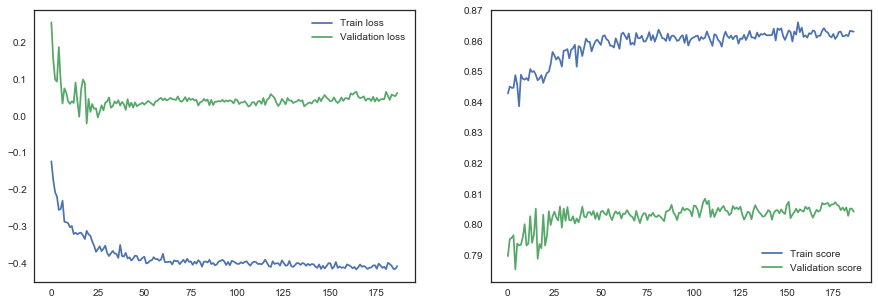

In [40]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric"], label="Validation score")
ax_score.legend()
plt.show()

## change structure --copy & freeze

In [81]:
def build_model_with_scblock(img_size_target):
    input_layer = Input((img_size_target, img_size_target, 2), name="input")
    output_layer = _build_model(input_layer, 16, 0.5, use_se=True, use_sigmoid=False, ssigmoid=False, se_l2_alpha=0.0001)

    model = Model(input_layer, output_layer)
    # c = SGD(lr=0.001, momentum=.9, decay=1e-6)
    # model.compile(loss=lovasz_loss_elu, optimizer=c, metrics=[my_iou_metric])
    return model


def build_model_with_scblock2(img_size_target):
    input_layer = Input((img_size_target, img_size_target, 2), name="input")
    output_layer = _build_model(input_layer, 16, 0.5, use_se=True, use_sigmoid=False, ssigmoid=True, se_l2_alpha=0.0001)

    model = Model(input_layer, output_layer)
    # c = SGD(lr=0.001, momentum=.9, decay=1e-6)
    # model.compile(loss=lovasz_loss_elu, optimizer=c, metrics=[my_iou_metric])
    return model


def copy_weights(target_model, source_model, freeze=False):
    for layer in source_model.layers:
        layer_name = layer.get_config()["name"]
        if "_conv" in layer_name or "_bn" in layer_name:
            print(layer_name)
            source_layer = source_model.get_layer(layer_name)
            target_layer = target_model.get_layer(layer_name)
            weights = source_layer.get_weights()
            target_layer.set_weights(weights)
            target_layer.trainable = not(freeze)


def load_model_add_scblock(filename, freeze=False):
    co = {
        "my_iou_metric_2": my_iou_metric_2
    }
    model_pretrained = load_model(filename, custom_objects=co)
    
    model_rebuild = build_model_with_scblock(101)
    copy_weights(model_rebuild, model_pretrained, freeze=freeze)

    c = SGD(lr=0.001, momentum=.9, decay=1e-6)
    model_rebuild.compile(loss=lovasz_loss_elu, optimizer=c, metrics=[my_iou_metric])
    return model_rebuild


def load_model_add_scblock2(filename, freeze=False):
    co = {
        "my_iou_metric_2": my_iou_metric_2
    }
    model_pretrained = load_model(filename, custom_objects=co)
    
    model_rebuild = build_model_with_scblock2(101)
    copy_weights(model_rebuild, model_pretrained, freeze=freeze)

    c = SGD(lr=0.001, momentum=.9, decay=1e-6)
    model_rebuild.compile(loss=lovasz_loss_elu, optimizer=c, metrics=[my_iou_metric])
    return model_rebuild

In [46]:
model = build_model_with_scblock(img_size_target)

In [50]:
# del model
gc.collect()
keras.backend.clear_session()

In [47]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 101, 101, 2)  0                                            
__________________________________________________________________________________________________
en1_a_conv (Conv2D)             (None, 101, 101, 16) 304         input[0][0]                      
__________________________________________________________________________________________________
en1_b_relu (Activation)         (None, 101, 101, 16) 0           en1_a_conv[0][0]                 
__________________________________________________________________________________________________
en1_b_bn (BatchNormalization)   (None, 101, 101, 16) 64          en1_b_relu[0][0]                 
__________________________________________________________________________________________________
en1_b_1_co

__________________________________________________________________________________________________
global_max_pooling2d_2 (GlobalM (None, 16)           0           en1_c_2_bn[0][0]                 
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 156)          97656       reshape_5[0][0]                  
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 4)            68          global_max_pooling2d_2[0][0]     
__________________________________________________________________________________________________
activation_27 (Activation)      (None, 156)          0           dense_7[0][0]                    
__________________________________________________________________________________________________
activation_25 (Activation)      (None, 4)            0           dense_5[0][0]                    
__________

__________________________________________________________________________________________________
reshape_9 (Reshape)             (None, 25, 25, 1)    0           activation_33[0][0]              
__________________________________________________________________________________________________
reshape_7 (Reshape)             (None, 1, 1, 32)     0           activation_31[0][0]              
__________________________________________________________________________________________________
conv2d_transpose_11 (Conv2DTran (None, 50, 50, 1)    10          reshape_9[0][0]                  
__________________________________________________________________________________________________
multiply_5 (Multiply)           (None, 50, 50, 32)   0           en2_b_2_bn[0][0]                 
                                                                 reshape_7[0][0]                  
__________________________________________________________________________________________________
multiply_6

__________________________________________________________________________________________________
en3_b_relu (Activation)         (None, 25, 25, 64)   0           en3_a_conv[0][0]                 
__________________________________________________________________________________________________
en3_b_bn (BatchNormalization)   (None, 25, 25, 64)   256         en3_b_relu[0][0]                 
__________________________________________________________________________________________________
en3_b_1_conv (Conv2D)           (None, 25, 25, 64)   36928       en3_b_bn[0][0]                   
__________________________________________________________________________________________________
en3_b_1_bn (BatchNormalization) (None, 25, 25, 64)   256         en3_b_1_conv[0][0]               
__________________________________________________________________________________________________
en3_b_1_relu (Activation)       (None, 25, 25, 64)   0           en3_b_1_bn[0][0]                 
__________

__________________________________________________________________________________________________
dense_24 (Dense)                (None, 625)          98125       activation_45[0][0]              
__________________________________________________________________________________________________
activation_44 (Activation)      (None, 64)           0           dense_22[0][0]                   
__________________________________________________________________________________________________
activation_46 (Activation)      (None, 625)          0           dense_24[0][0]                   
__________________________________________________________________________________________________
reshape_16 (Reshape)            (None, 1, 1, 64)     0           activation_44[0][0]              
__________________________________________________________________________________________________
reshape_18 (Reshape)            (None, 25, 25, 1)    0           activation_46[0][0]              
__________

__________________________________________________________________________________________________
en4_c_relu (Activation)         (None, 12, 12, 128)  0           en4_b_add[0][0]                  
__________________________________________________________________________________________________
en4_c_bn (BatchNormalization)   (None, 12, 12, 128)  512         en4_c_relu[0][0]                 
__________________________________________________________________________________________________
en4_c_1_conv (Conv2D)           (None, 12, 12, 128)  147584      en4_c_bn[0][0]                   
__________________________________________________________________________________________________
en4_c_1_bn (BatchNormalization) (None, 12, 12, 128)  512         en4_c_1_conv[0][0]               
__________________________________________________________________________________________________
en4_c_1_relu (Activation)       (None, 12, 12, 128)  0           en4_c_1_bn[0][0]                 
__________

vm_c_1_conv (Conv2D)            (None, 6, 6, 256)    590080      vm_c_bn[0][0]                    
__________________________________________________________________________________________________
vm_c_1_bn (BatchNormalization)  (None, 6, 6, 256)    1024        vm_c_1_conv[0][0]                
__________________________________________________________________________________________________
vm_c_1_relu (Activation)        (None, 6, 6, 256)    0           vm_c_1_bn[0][0]                  
__________________________________________________________________________________________________
vm_c_2_conv (Conv2D)            (None, 6, 6, 256)    590080      vm_c_1_relu[0][0]                
__________________________________________________________________________________________________
vm_c_2_bn (BatchNormalization)  (None, 6, 6, 256)    1024        vm_c_2_conv[0][0]                
__________________________________________________________________________________________________
vm_c_add (

de4_c_1_bn (BatchNormalization) (None, 12, 12, 128)  512         de4_c_1_conv[0][0]               
__________________________________________________________________________________________________
de4_c_1_relu (Activation)       (None, 12, 12, 128)  0           de4_c_1_bn[0][0]                 
__________________________________________________________________________________________________
de4_c_2_conv (Conv2D)           (None, 12, 12, 128)  147584      de4_c_1_relu[0][0]               
__________________________________________________________________________________________________
de4_c_2_bn (BatchNormalization) (None, 12, 12, 128)  512         de4_c_2_conv[0][0]               
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 12, 12, 1)    129         de4_c_2_bn[0][0]                 
__________________________________________________________________________________________________
global_max

__________________________________________________________________________________________________
activation_69 (Activation)      (None, 156)          0           dense_43[0][0]                   
__________________________________________________________________________________________________
dense_42 (Dense)                (None, 64)           1088        activation_67[0][0]              
__________________________________________________________________________________________________
dense_44 (Dense)                (None, 625)          98125       activation_69[0][0]              
__________________________________________________________________________________________________
activation_68 (Activation)      (None, 64)           0           dense_42[0][0]                   
__________________________________________________________________________________________________
activation_70 (Activation)      (None, 625)          0           dense_44[0][0]                   
__________

__________________________________________________________________________________________________
concatenate_11 (Concatenate)    (None, 50, 50, 64)   0           conv2d_transpose_15[0][0]        
                                                                 activation_38[0][0]              
__________________________________________________________________________________________________
dropout_25 (Dropout)            (None, 50, 50, 64)   0           concatenate_11[0][0]             
__________________________________________________________________________________________________
de2_a_conv (Conv2D)             (None, 50, 50, 32)   18464       dropout_25[0][0]                 
__________________________________________________________________________________________________
de2_b_relu (Activation)         (None, 50, 50, 32)   0           de2_a_conv[0][0]                 
__________________________________________________________________________________________________
de2_b_bn (

reshape_41 (Reshape)            (None, 625)          0           max_pooling2d_18[0][0]           
__________________________________________________________________________________________________
global_max_pooling2d_14 (Global (None, 32)           0           de2_c_2_bn[0][0]                 
__________________________________________________________________________________________________
dense_55 (Dense)                (None, 156)          97656       reshape_41[0][0]                 
__________________________________________________________________________________________________
dense_53 (Dense)                (None, 8)            264         global_max_pooling2d_14[0][0]    
__________________________________________________________________________________________________
activation_82 (Activation)      (None, 156)          0           dense_55[0][0]                   
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
activation_88 (Activation)      (None, 625)          0           dense_60[0][0]                   
__________________________________________________________________________________________________
activation_86 (Activation)      (None, 16)           0           dense_58[0][0]                   
__________________________________________________________________________________________________
reshape_45 (Reshape)            (None, 25, 25, 1)    0           activation_88[0][0]              
__________________________________________________________________________________________________
reshape_43 (Reshape)            (None, 1, 1, 16)     0           activation_86[0][0]              
__________________________________________________________________________________________________
conv2d_transpose_19 (Conv2DTran (None, 101, 101, 1)  26          reshape_45[0][0]                 
__________

__________________________________________________________________________________________________
final_conv (Conv2D)             (None, 101, 101, 1)  17          dropout_27[0][0]                 
Total params: 7,560,349
Trainable params: 7,551,517
Non-trainable params: 8,832
__________________________________________________________________________________________________


## finetune0 --fold 0 --branch with scbe block

In [82]:
for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-resnet-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    model_finetune0_filepath = "{}-model-resnet-finetune0-block1-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    log_finetune0_filepath = "{}-log-resnet-finetune0-block1-fold-{}-run-{}.csv".format(exp_code, i, run)
    
    # model_filepath = "{}-model-resnet-fold-{}-run-{}.hdf5".format(exp_code, i)
    # model_finetune0_filepath = "{}-model-resnet-finetune0-fold-{}.hdf5".format(exp_code, i)
    # log_finetune0_filepath = "{}-log-resnet-finetune0-fold-{}.csv".format(exp_code, i)

    print("mode:", model_filepath)
    print("model finetune0:", model_finetune0_filepath)
    print("log:", log_finetune0_filepath)
    metric_name = "val_my_iou_metric"

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=64, verbose=1)
    model_checkpoint = ModelCheckpoint(model_finetune0_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=8, min_lr=0.0001, verbose=1)
    model_logger = CSVLogger(log_finetune0_filepath, separator=',', append=False)

    epochs = 1000
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    X_train = np.array([append_depth_channel(x) for x in X_train])
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    X_valid = np.array([append_depth_channel(x) for x in X_valid])

    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    model_rebuild = load_model_add_scblock(model_filepath)
    print("build model.")
    
    def train():
        return model_rebuild.fit(X_train, Y_train,
                                 validation_data=[X_valid, Y_valid], 
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger], 
                                 verbose=200)
    
    %time history = train()
    break

fold: 0
run: 1
index.shape: (3196,) (804,)
mode: 029-model-resnet-fold-0-run-1.hdf5
model finetune0: 029-model-resnet-finetune0-block1-fold-0-run-1.hdf5
log: 029-log-resnet-finetune0-block1-fold-0-run-1.csv
data.shape: (6392, 101, 101, 2) (6392, 101, 101, 1) (804, 101, 101, 2) (804, 101, 101, 1)
en1_a_conv
en1_b_bn
en1_b_1_conv
en1_b_1_bn
en1_b_2_conv
en1_b_2_bn
en1_c_bn
en1_c_1_conv
en1_c_1_bn
en1_c_2_conv
en1_c_2_bn
en2_a_conv
en2_b_bn
en2_b_1_conv
en2_b_1_bn
en2_b_2_conv
en2_b_2_bn
en2_c_bn
en2_c_1_conv
en2_c_1_bn
en2_c_2_conv
en2_c_2_bn
en3_a_conv
en3_b_bn
en3_b_1_conv
en3_b_1_bn
en3_b_2_conv
en3_b_2_bn
en3_c_bn
en3_c_1_conv
en3_c_1_bn
en3_c_2_conv
en3_c_2_bn
en4_a_conv
en4_b_bn
en4_b_1_conv
en4_b_1_bn
en4_b_2_conv
en4_b_2_bn
en4_c_bn
en4_c_1_conv
en4_c_1_bn
en4_c_2_conv
en4_c_2_bn
vm_a_conv
vm_b_bn
vm_b_1_conv
vm_b_1_bn
vm_b_2_conv
vm_b_2_bn
vm_c_bn
vm_c_1_conv
vm_c_1_bn
vm_c_2_conv
vm_c_2_bn
de4_a_conv
de4_b_bn
de4_b_1_conv
de4_b_1_bn
de4_b_2_conv
de4_b_2_bn
de4_c_bn
de4_c_1_conv

Epoch 00072: val_my_iou_metric did not improve from 0.80435
Epoch 73/1000

Epoch 00073: val_my_iou_metric did not improve from 0.80435
Epoch 74/1000

Epoch 00074: val_my_iou_metric did not improve from 0.80435
Epoch 75/1000

Epoch 00075: val_my_iou_metric did not improve from 0.80435
Epoch 76/1000

Epoch 00076: val_my_iou_metric did not improve from 0.80435
Epoch 77/1000

Epoch 00077: val_my_iou_metric did not improve from 0.80435
Epoch 78/1000

Epoch 00078: val_my_iou_metric did not improve from 0.80435
Epoch 79/1000

Epoch 00079: val_my_iou_metric did not improve from 0.80435
Epoch 80/1000

Epoch 00080: val_my_iou_metric did not improve from 0.80435
Epoch 81/1000


KeyboardInterrupt: 

## finetune0 --fold 0 --branch with scbe block freeze

## finetune0 --fold 0 --Fbranch scblock2

In [64]:
for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-resnet-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    model_finetune0_filepath = "{}-model-resnet-finetune0-block2-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    log_finetune0_filepath = "{}-log-resnet-finetune0-block2-fold-{}-run-{}.csv".format(exp_code, i, run)

    print("mode:", model_filepath)
    print("model finetune0:", model_finetune0_filepath)
    print("log:", log_finetune0_filepath)
    metric_name = "val_my_iou_metric"

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=64, verbose=1)
    model_checkpoint = ModelCheckpoint(model_finetune0_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=8, min_lr=0.0001, verbose=1)
    model_logger = CSVLogger(log_finetune0_filepath, separator=',', append=False)

    epochs = 1000
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    X_train = np.array([append_depth_channel(x) for x in X_train])
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    X_valid = np.array([append_depth_channel(x) for x in X_valid])

    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    model_rebuild = load_model_add_scblock2(model_filepath)
    print("build model.")
    
    def train():
        return model_rebuild.fit(X_train, Y_train,
                                 validation_data=[X_valid, Y_valid], 
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger], 
                                 verbose=200)
    
    %time history = train()
    break

fold: 0
run: 1
index.shape: (3196,) (804,)
mode: 029-model-resnet-fold-0-run-1.hdf5
model finetune0: 029-model-resnet-finetune0-block2-fold-0-run-1.hdf5
log: 029-log-resnet-finetune0-block2-fold-0-run-1.csv
data.shape: (6392, 101, 101, 2) (6392, 101, 101, 1) (804, 101, 101, 2) (804, 101, 101, 1)
en1_a_conv
en1_b_bn
en1_b_1_conv
en1_b_1_bn
en1_b_2_conv
en1_b_2_bn
en1_c_bn
en1_c_1_conv
en1_c_1_bn
en1_c_2_conv
en1_c_2_bn
en2_a_conv
en2_b_bn
en2_b_1_conv
en2_b_1_bn
en2_b_2_conv
en2_b_2_bn
en2_c_bn
en2_c_1_conv
en2_c_1_bn
en2_c_2_conv
en2_c_2_bn
en3_a_conv
en3_b_bn
en3_b_1_conv
en3_b_1_bn
en3_b_2_conv
en3_b_2_bn
en3_c_bn
en3_c_1_conv
en3_c_1_bn
en3_c_2_conv
en3_c_2_bn
en4_a_conv
en4_b_bn
en4_b_1_conv
en4_b_1_bn
en4_b_2_conv
en4_b_2_bn
en4_c_bn
en4_c_1_conv
en4_c_1_bn
en4_c_2_conv
en4_c_2_bn
vm_a_conv
vm_b_bn
vm_b_1_conv
vm_b_1_bn
vm_b_2_conv
vm_b_2_bn
vm_c_bn
vm_c_1_conv
vm_c_1_bn
vm_c_2_conv
vm_c_2_bn
de4_a_conv
de4_b_bn
de4_b_1_conv
de4_b_1_bn
de4_b_2_conv
de4_b_2_bn
de4_c_bn
de4_c_1_conv

KeyboardInterrupt: 

## finetune3 --fold0

In [76]:
def load_finetune2_model(filename):
    co = {
        "lovasz_loss": lovasz_loss,
        "my_iou_metric": my_iou_metric
    }
    model_pretrained = load_model(filename, custom_objects=co)
    
    # model_rebuild = build_model_complex(101)
    # copy_weights(model_rebuild, model_pretrained)

    c = SGD(lr=0.005, momentum=0.9, decay=1e-6)
    model_pretrained.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric])
    return model_pretrained

In [77]:
for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-resnet-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    model_finetune0_filepath = "{}-model-resnet-finetune0-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    log_finetune0_filepath = "{}-log-resnet-finetune0--fold-{}-run-{}.csv".format(exp_code, i, run)

    model_filepath = "{}-model-resnet-fold-{}.hdf5".format(exp_code, i)
    model_finetune1_filepath = "{}-model-resnet-finetune1-fold-{}.hdf5".format(exp_code, i)
    model_finetune2_filepath = "{}-model-resnet-finetune2-fold-{}.hdf5".format(exp_code, i)
    model_finetune3_filepath = "{}-model-resnet-finetune3-fold-{}.hdf5".format(exp_code, i)
    log_finetune3_filepath = "{}-log-resnet-finetune3-fold-{}.csv".format(exp_code, i)

    print("mode:", model_finetune1_filepath)
    print("model finetune0:", model_finetune3_filepath)
    print("log:", log_finetune3_filepath)
    metric_name = "val_my_iou_metric"

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=32, verbose=1)
    model_checkpoint = ModelCheckpoint(model_finetune3_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=8, min_lr=0.00001, verbose=1) # factor = 0.5
    model_logger = CSVLogger(log_finetune3_filepath, separator=',', append=False)

    epochs = 500 # 500
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    X_train = np.array([append_depth_channel(x) for x in X_train])
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    X_valid = np.array([append_depth_channel(x) for x in X_valid])

    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    model_rebuild = load_finetune2_model(model_finetune2_filepath)
    print("build model.")
    
    def train():
        return model_rebuild.fit(X_train, Y_train,
                                 validation_data=[X_valid, Y_valid], 
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger], 
                                 verbose=200)
    
    %time train()
    break

fold: 0
run: 0
index.shape: (3196,) (804,)
mode: 025-model-resnet-finetune1-fold-0.hdf5
model finetune0: 025-model-resnet-finetune3-fold-0.hdf5
log: 025-log-resnet-finetune3-fold-0.csv
data.shape: (6392, 101, 101, 2) (6392, 101, 101, 1) (804, 101, 101, 2) (804, 101, 101, 1)
build model.
Train on 6392 samples, validate on 804 samples
Epoch 1/500

Epoch 00001: val_my_iou_metric improved from -inf to 0.78445, saving model to 025-model-resnet-finetune3-fold-0.hdf5
Epoch 2/500

Epoch 00002: val_my_iou_metric improved from 0.78445 to 0.78607, saving model to 025-model-resnet-finetune3-fold-0.hdf5
Epoch 3/500

Epoch 00003: val_my_iou_metric did not improve from 0.78607
Epoch 4/500

Epoch 00004: val_my_iou_metric improved from 0.78607 to 0.78769, saving model to 025-model-resnet-finetune3-fold-0.hdf5
Epoch 5/500

Epoch 00005: val_my_iou_metric did not improve from 0.78769
Epoch 6/500

Epoch 00006: val_my_iou_metric did not improve from 0.78769
Epoch 7/500

Epoch 00007: val_my_iou_metric did no

## finetune4 --fold 0

In [20]:
def load_finetune3_model(filename):
    co = {
        "lovasz_loss": lovasz_loss,
        "my_iou_metric": my_iou_metric
    }
    model_pretrained = load_model(filename, custom_objects=co)
    
    # model_rebuild = build_model_complex(101)
    # copy_weights(model_rebuild, model_pretrained)

    c = SGD(lr=0.002, momentum=0.9, decay=1e-6)
    model_pretrained.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric])
    return model_pretrained

In [25]:
run = 0

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-resnet-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    model_finetune0_filepath = "{}-model-resnet-finetune0-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    log_finetune0_filepath = "{}-log-resnet-finetune0--fold-{}-run-{}.csv".format(exp_code, i, run)

    model_filepath = "{}-model-resnet-fold-{}.hdf5".format(exp_code, i)
    model_finetune1_filepath = "{}-model-resnet-finetune1-fold-{}.hdf5".format(exp_code, i)
    model_finetune2_filepath = "{}-model-resnet-finetune2-fold-{}.hdf5".format(exp_code, i)
    model_finetune3_filepath = "{}-model-resnet-finetune3-fold-{}.hdf5".format(exp_code, i)
    model_finetune4_filepath = "{}-model-resnet-finetune4-fold-{}.hdf5".format(exp_code, i)
    log_finetune4_filepath = "{}-log-resnet-finetune4-fold-{}.csv".format(exp_code, i)

    print("mode:", model_finetune3_filepath)
    print("model finetune4:", model_finetune4_filepath)
    print("log:", log_finetune4_filepath)
    metric_name = "val_my_iou_metric"

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=60, verbose=1)
    model_checkpoint = ModelCheckpoint(model_finetune4_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.75, patience=15, min_lr=0.00001, verbose=1) # factor = 0.5
    model_logger = CSVLogger(log_finetune4_filepath, separator=',', append=False)

    epochs = 1000 # 500
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    X_train = np.array([append_depth_channel(x) for x in X_train])
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    X_valid = np.array([append_depth_channel(x) for x in X_valid])

    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    # model_rebuild = load_finetune3_model(model_finetune3_filepath)
    model_rebuild = load_finetune3_model(model_finetune4_filepath) # continue
    print("build model.")
    
    def train():
        return model_rebuild.fit(X_train, Y_train,
                                 validation_data=[X_valid, Y_valid], 
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger], 
                                 verbose=200)
    
    %time train()
    break

fold: 0
run: 0
index.shape: (3196,) (804,)
mode: 025-model-resnet-finetune3-fold-0.hdf5
model finetune4: 025-model-resnet-finetune4-fold-0.hdf5
log: 025-log-resnet-finetune4-fold-0.csv
data.shape: (6392, 101, 101, 2) (6392, 101, 101, 1) (804, 101, 101, 2) (804, 101, 101, 1)
build model.
Train on 6392 samples, validate on 804 samples
Epoch 1/1000

Epoch 00001: val_my_iou_metric improved from -inf to 0.79689, saving model to 025-model-resnet-finetune4-fold-0.hdf5
Epoch 2/1000

Epoch 00002: val_my_iou_metric did not improve from 0.79689
Epoch 3/1000

Epoch 00003: val_my_iou_metric improved from 0.79689 to 0.79813, saving model to 025-model-resnet-finetune4-fold-0.hdf5
Epoch 4/1000

Epoch 00004: val_my_iou_metric did not improve from 0.79813
Epoch 5/1000

Epoch 00005: val_my_iou_metric did not improve from 0.79813
Epoch 6/1000

Epoch 00006: val_my_iou_metric did not improve from 0.79813
Epoch 7/1000

Epoch 00007: val_my_iou_metric did not improve from 0.79813
Epoch 8/1000

Epoch 00008: val

## finetune5 --fold 0

In [30]:
def load_finetune4_model(filename):
    co = {
        "lovasz_loss": lovasz_loss,
        "my_iou_metric": my_iou_metric
    }
    model_pretrained = load_model(filename, custom_objects=co)
    
    # model_rebuild = build_model_complex(101)
    # copy_weights(model_rebuild, model_pretrained)

    # c = SGD(lr=0.002, momentum=0.9, decay=1e-6)
    c = Adadelta()
    model_pretrained.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric])
    return model_pretrained

In [28]:
run = 0

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-resnet-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    model_finetune0_filepath = "{}-model-resnet-finetune0-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    log_finetune0_filepath = "{}-log-resnet-finetune0--fold-{}-run-{}.csv".format(exp_code, i, run)

    model_filepath = "{}-model-resnet-fold-{}.hdf5".format(exp_code, i)
    model_finetune1_filepath = "{}-model-resnet-finetune1-fold-{}.hdf5".format(exp_code, i)
    model_finetune2_filepath = "{}-model-resnet-finetune2-fold-{}.hdf5".format(exp_code, i)
    model_finetune3_filepath = "{}-model-resnet-finetune3-fold-{}.hdf5".format(exp_code, i)
    model_finetune4_filepath = "{}-model-resnet-finetune4-fold-{}.hdf5".format(exp_code, i)
    model_finetune5_filepath = "{}-model-resnet-finetune5-fold-{}.hdf5".format(exp_code, i)
    log_finetune5_filepath = "{}-log-resnet-finetune5-fold-{}.csv".format(exp_code, i)

    print("mode:", model_finetune4_filepath)
    print("model finetune4:", model_finetune5_filepath)
    print("log:", log_finetune5_filepath)
    metric_name = "val_my_iou_metric"

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=50, verbose=1)
    model_checkpoint = ModelCheckpoint(model_finetune5_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    # reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.75, patience=15, min_lr=0.00001, verbose=1) # factor = 0.5
    model_logger = CSVLogger(log_finetune5_filepath, separator=',', append=False)

    epochs = 1000 # 500
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    X_train = np.array([append_depth_channel(x) for x in X_train])
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    X_valid = np.array([append_depth_channel(x) for x in X_valid])

    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    # model_rebuild = load_finetune3_model(model_finetune3_filepath)
    model_rebuild = load_finetune3_model(model_finetune4_filepath) # 
    # model_rebuild = load_finetune3_model(model_finetune5_filepath)
    print("build model.")
    
    def train():
        return model_rebuild.fit(X_train, Y_train,
                                 validation_data=[X_valid, Y_valid], 
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 callbacks=[early_stopping, model_checkpoint, model_logger], 
                                 verbose=200)
    
    %time train()
    break

fold: 0
run: 0
index.shape: (3196,) (804,)
mode: 025-model-resnet-finetune4-fold-0.hdf5
model finetune4: 025-model-resnet-finetune5-fold-0.hdf5
log: 025-log-resnet-finetune5-fold-0.csv
data.shape: (6392, 101, 101, 2) (6392, 101, 101, 1) (804, 101, 101, 2) (804, 101, 101, 1)
build model.
Train on 6392 samples, validate on 804 samples
Epoch 1/1000

Epoch 00001: val_my_iou_metric improved from -inf to 0.79391, saving model to 025-model-resnet-finetune5-fold-0.hdf5
Epoch 2/1000

Epoch 00002: val_my_iou_metric improved from 0.79391 to 0.79602, saving model to 025-model-resnet-finetune5-fold-0.hdf5
Epoch 3/1000

Epoch 00003: val_my_iou_metric did not improve from 0.79602
Epoch 4/1000

Epoch 00004: val_my_iou_metric did not improve from 0.79602
Epoch 5/1000

Epoch 00005: val_my_iou_metric improved from 0.79602 to 0.79751, saving model to 025-model-resnet-finetune5-fold-0.hdf5
Epoch 6/1000

Epoch 00006: val_my_iou_metric did not improve from 0.79751
Epoch 7/1000

Epoch 00007: val_my_iou_metric

## finetune6 --fold 0

In [29]:
def load_finetune3_model(filename):
    co = {
        "lovasz_loss": lovasz_loss,
        "my_iou_metric": my_iou_metric
    }
    model_pretrained = load_model(filename, custom_objects=co)
    
    # model_rebuild = build_model_complex(101)
    # copy_weights(model_rebuild, model_pretrained)

    c = SGD(lr=0.002, momentum=0.9, decay=1e-6)
    model_pretrained.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric])
    return model_pretrained

In [31]:
run = 0

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    prev_round = 5
    cur_round = 6
    
    model_filepath = "{}-model-resnet-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    model_finetune0_filepath = "{}-model-resnet-finetune0-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    log_finetune0_filepath = "{}-log-resnet-finetune0--fold-{}-run-{}.csv".format(exp_code, i, run)

    model_filepath = "{}-model-resnet-fold-{}.hdf5".format(exp_code, i)
    model_finetune1_filepath = "{}-model-resnet-finetune1-fold-{}.hdf5".format(exp_code, i)
    model_finetune2_filepath = "{}-model-resnet-finetune2-fold-{}.hdf5".format(exp_code, i)
    model_finetune3_filepath = "{}-model-resnet-finetune3-fold-{}.hdf5".format(exp_code, i)
    model_finetune4_filepath = "{}-model-resnet-finetune4-fold-{}.hdf5".format(exp_code, i)
    model_finetune5_filepath = "{}-model-resnet-finetune5-fold-{}.hdf5".format(exp_code, i)
    
    model_filepath_prev = "{}-model-resnet-finetune{}-fold-{}.hdf5".format(exp_code, prev_round, i)
    model_filepath_cur =  "{}-model-resnet-finetune{}-fold-{}.hdf5".format(exp_code, cur_round, i)
    log_filepath_cur = "{}-log-resnet-finetune{}-fold-{}.csv".format(exp_code, cur_round, i)

    print("mode pretrained:", model_filepath_prev)
    print("model next:", model_filepath_cur)
    print("log:", log_filepath_cur)
    metric_name = "val_my_iou_metric"

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=50, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath_cur, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    # reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.75, patience=15, min_lr=0.00001, verbose=1) # factor = 0.5
    model_logger = CSVLogger(log_filepath_cur, separator=',', append=False)

    epochs = 1000 # 500
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    X_train = np.array([append_depth_channel(x) for x in X_train])
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    X_valid = np.array([append_depth_channel(x) for x in X_valid])

    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    # model_rebuild = load_finetune3_model(model_finetune3_filepath)
    model_rebuild = load_finetune4_model(model_filepath_prev) # 
    # model_rebuild = load_finetune3_model(model_finetune5_filepath)
    print("build model.")
    
    def train():
        return model_rebuild.fit(X_train, Y_train,
                                 validation_data=[X_valid, Y_valid], 
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 callbacks=[early_stopping, model_checkpoint, model_logger], 
                                 verbose=200)
    
    %time train()
    break

fold: 0
run: 0
index.shape: (3196,) (804,)
mode pretrained: 025-model-resnet-finetune5-fold-0.hdf5
model next: 025-model-resnet-finetune6-fold-0.hdf5
log: 025-log-resnet-finetune6-fold-0.csv
data.shape: (6392, 101, 101, 2) (6392, 101, 101, 1) (804, 101, 101, 2) (804, 101, 101, 1)
build model.
Train on 6392 samples, validate on 804 samples
Epoch 1/1000

Epoch 00001: val_my_iou_metric improved from -inf to 0.78669, saving model to 025-model-resnet-finetune6-fold-0.hdf5
Epoch 2/1000

Epoch 00002: val_my_iou_metric improved from 0.78669 to 0.79266, saving model to 025-model-resnet-finetune6-fold-0.hdf5
Epoch 3/1000

Epoch 00003: val_my_iou_metric did not improve from 0.79266
Epoch 4/1000

Epoch 00004: val_my_iou_metric did not improve from 0.79266
Epoch 5/1000

Epoch 00005: val_my_iou_metric did not improve from 0.79266
Epoch 6/1000

Epoch 00006: val_my_iou_metric improved from 0.79266 to 0.80236, saving model to 025-model-resnet-finetune6-fold-0.hdf5
Epoch 7/1000

Epoch 00007: val_my_iou_

## finetune7 --fold 0

In [32]:
run = 0

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    prev_round = 6
    cur_round = 7
    
    model_filepath = "{}-model-resnet-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    model_finetune0_filepath = "{}-model-resnet-finetune0-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    log_finetune0_filepath = "{}-log-resnet-finetune0--fold-{}-run-{}.csv".format(exp_code, i, run)

    model_filepath = "{}-model-resnet-fold-{}.hdf5".format(exp_code, i)
    model_finetune1_filepath = "{}-model-resnet-finetune1-fold-{}.hdf5".format(exp_code, i)
    model_finetune2_filepath = "{}-model-resnet-finetune2-fold-{}.hdf5".format(exp_code, i)
    model_finetune3_filepath = "{}-model-resnet-finetune3-fold-{}.hdf5".format(exp_code, i)
    model_finetune4_filepath = "{}-model-resnet-finetune4-fold-{}.hdf5".format(exp_code, i)
    model_finetune5_filepath = "{}-model-resnet-finetune5-fold-{}.hdf5".format(exp_code, i)
    
    model_filepath_prev = "{}-model-resnet-finetune{}-fold-{}.hdf5".format(exp_code, prev_round, i)
    model_filepath_cur =  "{}-model-resnet-finetune{}-fold-{}.hdf5".format(exp_code, cur_round, i)
    log_filepath_cur = "{}-log-resnet-finetune{}-fold-{}.csv".format(exp_code, cur_round, i)

    print("mode pretrained:", model_filepath_prev)
    print("model next:", model_filepath_cur)
    print("log:", log_filepath_cur)
    metric_name = "val_my_iou_metric"

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=50, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath_cur, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    # reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.75, patience=15, min_lr=0.00001, verbose=1) # factor = 0.5
    model_logger = CSVLogger(log_filepath_cur, separator=',', append=False)

    epochs = 1000 # 500
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    X_train = np.array([append_depth_channel(x) for x in X_train])
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    X_valid = np.array([append_depth_channel(x) for x in X_valid])

    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    # model_rebuild = load_finetune3_model(model_finetune3_filepath)
    model_rebuild = load_finetune3_model(model_filepath_prev) # 
    # model_rebuild = load_finetune3_model(model_finetune5_filepath)
    print("build model.")
    
    def train():
        return model_rebuild.fit(X_train, Y_train,
                                 validation_data=[X_valid, Y_valid], 
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 callbacks=[early_stopping, model_checkpoint, model_logger], 
                                 verbose=200)
    
    %time train()
    break

fold: 0
run: 0
index.shape: (3196,) (804,)
mode pretrained: 025-model-resnet-finetune6-fold-0.hdf5
model next: 025-model-resnet-finetune7-fold-0.hdf5
log: 025-log-resnet-finetune7-fold-0.csv
data.shape: (6392, 101, 101, 2) (6392, 101, 101, 1) (804, 101, 101, 2) (804, 101, 101, 1)
build model.
Train on 6392 samples, validate on 804 samples
Epoch 1/1000

Epoch 00001: val_my_iou_metric improved from -inf to 0.79017, saving model to 025-model-resnet-finetune7-fold-0.hdf5
Epoch 2/1000

Epoch 00002: val_my_iou_metric improved from 0.79017 to 0.80100, saving model to 025-model-resnet-finetune7-fold-0.hdf5
Epoch 3/1000

Epoch 00003: val_my_iou_metric did not improve from 0.80100
Epoch 4/1000

Epoch 00004: val_my_iou_metric did not improve from 0.80100
Epoch 5/1000

Epoch 00005: val_my_iou_metric did not improve from 0.80100
Epoch 6/1000

Epoch 00006: val_my_iou_metric did not improve from 0.80100
Epoch 7/1000

Epoch 00007: val_my_iou_metric did not improve from 0.80100
Epoch 8/1000

Epoch 0000

## finetune8 --fold 0

In [47]:
def load_finetune3_model(filename):
    co = {
        "lovasz_loss": lovasz_loss,
        "my_iou_metric": my_iou_metric
    }
    model_pretrained = load_model(filename, custom_objects=co)
    
    # model_rebuild = build_model_complex(101)
    # copy_weights(model_rebuild, model_pretrained)

    # c = SGD(lr=0.001, momentum=0.9, decay=1e-6)
    c = Adam(lr=0.001)
    # c = RMSprop(lr=0.001)
    model_pretrained.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric]) ## new loss
    return model_pretrained

In [50]:
run = 0

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    prev_round = 7
    cur_round = 8
    
    model_filepath = "{}-model-resnet-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    model_finetune0_filepath = "{}-model-resnet-finetune0-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    log_finetune0_filepath = "{}-log-resnet-finetune0--fold-{}-run-{}.csv".format(exp_code, i, run)

    model_filepath = "{}-model-resnet-fold-{}.hdf5".format(exp_code, i)
    model_finetune1_filepath = "{}-model-resnet-finetune1-fold-{}.hdf5".format(exp_code, i)
    model_finetune2_filepath = "{}-model-resnet-finetune2-fold-{}.hdf5".format(exp_code, i)
    model_finetune3_filepath = "{}-model-resnet-finetune3-fold-{}.hdf5".format(exp_code, i)
    model_finetune4_filepath = "{}-model-resnet-finetune4-fold-{}.hdf5".format(exp_code, i)
    model_finetune5_filepath = "{}-model-resnet-finetune5-fold-{}.hdf5".format(exp_code, i)
    
    model_filepath_prev = "{}-model-resnet-finetune{}-fold-{}.hdf5".format(exp_code, prev_round, i)
    model_filepath_cur =  "{}-model-resnet-finetune{}-fold-{}.hdf5".format(exp_code, cur_round, i)
    log_filepath_cur = "{}-log-resnet-finetune{}-fold-{}.csv".format(exp_code, cur_round, i)

    print("mode pretrained:", model_filepath_prev)
    print("model next:", model_filepath_cur)
    print("log:", log_filepath_cur)
    metric_name = "val_my_iou_metric"

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=64, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath_cur, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=8, min_lr=0.0001, verbose=1) # factor = 0.5
    model_logger = CSVLogger(log_filepath_cur, separator=',', append=False)

    epochs = 1000 # 500
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    X_train = np.array([append_depth_channel(x) for x in X_train])
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    X_valid = np.array([append_depth_channel(x) for x in X_valid])

    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    # model_rebuild = load_finetune3_model(model_finetune3_filepath)
    # model_rebuild = load_finetune3_model(model_filepath_prev) # 
    model_rebuild = load_finetune3_model(model_filepath_cur) # 
    # model_rebuild = load_finetune3_model(model_finetune5_filepath)
    print("build model.")
    
    def train():
        return model_rebuild.fit(X_train, Y_train,
                                 validation_data=[X_valid, Y_valid], 
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger], 
                                 verbose=200)
    
    %time train() 
    break

fold: 0
run: 0
index.shape: (3196,) (804,)
mode pretrained: 025-model-resnet-finetune7-fold-0.hdf5
model next: 025-model-resnet-finetune8-fold-0.hdf5
log: 025-log-resnet-finetune8-fold-0.csv
data.shape: (6392, 101, 101, 2) (6392, 101, 101, 1) (804, 101, 101, 2) (804, 101, 101, 1)
build model.
Train on 6392 samples, validate on 804 samples
Epoch 1/1000

Epoch 00001: val_my_iou_metric improved from -inf to 0.75609, saving model to 025-model-resnet-finetune8-fold-0.hdf5
Epoch 2/1000

Epoch 00002: val_my_iou_metric improved from 0.75609 to 0.77749, saving model to 025-model-resnet-finetune8-fold-0.hdf5
Epoch 3/1000

Epoch 00003: val_my_iou_metric improved from 0.77749 to 0.78582, saving model to 025-model-resnet-finetune8-fold-0.hdf5
Epoch 4/1000

Epoch 00004: val_my_iou_metric did not improve from 0.78582
Epoch 5/1000

Epoch 00005: val_my_iou_metric did not improve from 0.78582
Epoch 6/1000

Epoch 00006: val_my_iou_metric did not improve from 0.78582
Epoch 7/1000

Epoch 00007: val_my_iou_